In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from scipy.interpolate import interp1d
import utils
import preprocess
import data

In [11]:
seq_len = 1024
feature_size = 467
record_pattern = 'sei_seq{}_nip_feature{}'.format(seq_len, feature_size)

test_prediction = np.load('../model/{}.test_predictions.npy'.format(record_pattern), allow_pickle=True).item()

preds = test_prediction['predictions']
targets = test_prediction['targets']

In [12]:
#test purpose - change to full pass

aucs=[]
aps = []
pr_ys = []
roc_ys = []
Ns = []
x_formatted = np.linspace(0,1,1000)


for i in range(preds.shape[1]):
    print(i)
    N = targets[:,i].sum()
    if N>25:
        pred = preds[:,i]
        target = targets[:,i]
        auc = roc_auc_score(target,pred)
        ap = average_precision_score(target,pred)
        pr_y, pr_x, _ = precision_recall_curve(target,pred)
        roc_x, roc_y, _ = roc_curve(target,pred)
        aucs.append(auc)
        aps.append(ap)
        #reduce the curves to 1000 dots
        roc_ys.append(interp1d(roc_x, roc_y)(x_formatted))
        pr_ys.append(interp1d(pr_x, pr_y)(x_formatted))
        Ns.append(N)
        print(auc)
        print(ap)
    else:
        aucs.append(np.nan)
        aps.append(np.nan)
        Ns.append(np.nan)
        pr_ys.append(np.nan)
        roc_ys.append(np.nan)

0
0.9320125823661778
0.3146208468040052
1
0.8682538560068148
0.3767911377542134
2
0.8902599280428579
0.5300539729312659
3
0.956868276472283
0.7145147202832035
4
0.9451994894342667
0.361108787326058
5
0.9070292130621469
0.8260324121619356
6
0.9082670309803256
0.8178298230380954
7
0.9100781484251147
0.8391364805504388
8
0.9108418055003087
0.8328723357380585
9
0.9071806026804532
0.26449654828302993
10
0.9488856172919756
0.41588392131065305
11
0.9055376844315872
0.19910569553996765
12
0.9155472558783698
0.6558193651991295
13
0.9144909435229859
0.7059308167621259
14
0.8808213707003238
0.523693884559342
15
0.9177744167487112
0.6700652393033057
16
0.9463667599718296
0.8452558953914014
17
0.9220477784009989
0.5023432288186122
18
0.7540792936168935
0.21044837614432677
19
0.9147671469553964
0.7115967135859765
20
0.8734875001658646
0.4320929562572563
21
0.9056871523035884
0.5769842197277204
22
0.933472516101705
0.7869429390159721
23
0.9507156018410642
0.36595928310311526
24
0.7680201081086935
0.0

In [31]:
with open('../training/osat_training_taglist_class.txt') as f:
    classinfo = [rec.strip() for rec in f.readlines()]

histone_inds = []
tf_inds = []
access_inds = []

for i,rec in enumerate(classinfo):
    category = rec.split('\t')[1]
    if category == 'TF':
        tf_inds.append(i)
    elif category == 'Histone':
        histone_inds.append(i)
    else:
        access_inds.append(i)

In [32]:
pr_baseline = np.array(Ns)/targets.shape[0] # 各个类别的序列数量占比
x_formatted = np.concatenate([x_formatted, [1]])
pr_y_formatted = np.vstack([p for p in pr_ys if isinstance(p, np.ndarray)])
roc_y_formatted = np.vstack([p for p in roc_ys if isinstance(p, np.ndarray)])
pr_y_formatted = np.concatenate([pr_y_formatted, pr_baseline[~np.isnan(pr_baseline),None]],axis=1)
inds_formatted =np.argwhere(~np.isnan(pr_baseline)).squeeze()

In [33]:
plotdata = pd.concat([pd.DataFrame({'x':x_formatted,'y50':np.percentile(pr_y_formatted[np.isin(inds_formatted, tf_inds),:], 50, axis=0),
                     'y75':np.percentile(pr_y_formatted[np.isin(inds_formatted, tf_inds),:], 75, axis=0),
                     'y25':np.percentile(pr_y_formatted[np.isin(inds_formatted, tf_inds),:], 25, axis=0),
                     'y5':np.percentile(pr_y_formatted[np.isin(inds_formatted, tf_inds),:], 5, axis=0),
                     'y95':np.percentile(pr_y_formatted[np.isin(inds_formatted, tf_inds),:], 95, axis=0),
                     'target':'TF'}),
                   pd.DataFrame({'x':x_formatted,'y50':np.percentile(pr_y_formatted[np.isin(inds_formatted, histone_inds),:], 50, axis=0),
                     'y75':np.percentile(pr_y_formatted[np.isin(inds_formatted, histone_inds),:], 75, axis=0),
                     'y25':np.percentile(pr_y_formatted[np.isin(inds_formatted, histone_inds),:], 25, axis=0),
                     'y5':np.percentile(pr_y_formatted[np.isin(inds_formatted, histone_inds),:], 5, axis=0),
                     'y95':np.percentile(pr_y_formatted[np.isin(inds_formatted, histone_inds),:], 95, axis=0),
                     'target':'Histone'}),
                   pd.DataFrame({'x':x_formatted,'y50':np.percentile(pr_y_formatted[np.isin(inds_formatted, access_inds),:], 50, axis=0),
                     'y75':np.percentile(pr_y_formatted[np.isin(inds_formatted, access_inds),:], 75, axis=0),
                     'y25':np.percentile(pr_y_formatted[np.isin(inds_formatted, access_inds),:], 25, axis=0),
                     'y5':np.percentile(pr_y_formatted[np.isin(inds_formatted, access_inds),:], 5, axis=0),
                     'y95':np.percentile(pr_y_formatted[np.isin(inds_formatted, access_inds),:], 95, axis=0),
                     'target':'Chromatin accessibility'})])

In [34]:
%load_ext rpy2.ipython

//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame


[1] "Transcription factor"    "Histone"                
[3] "Chromatin accessibility"
Saving 10 x 5 in image


Loading required package: ggplot2
In addition: Warning messages:
1: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages
2: `legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing` 


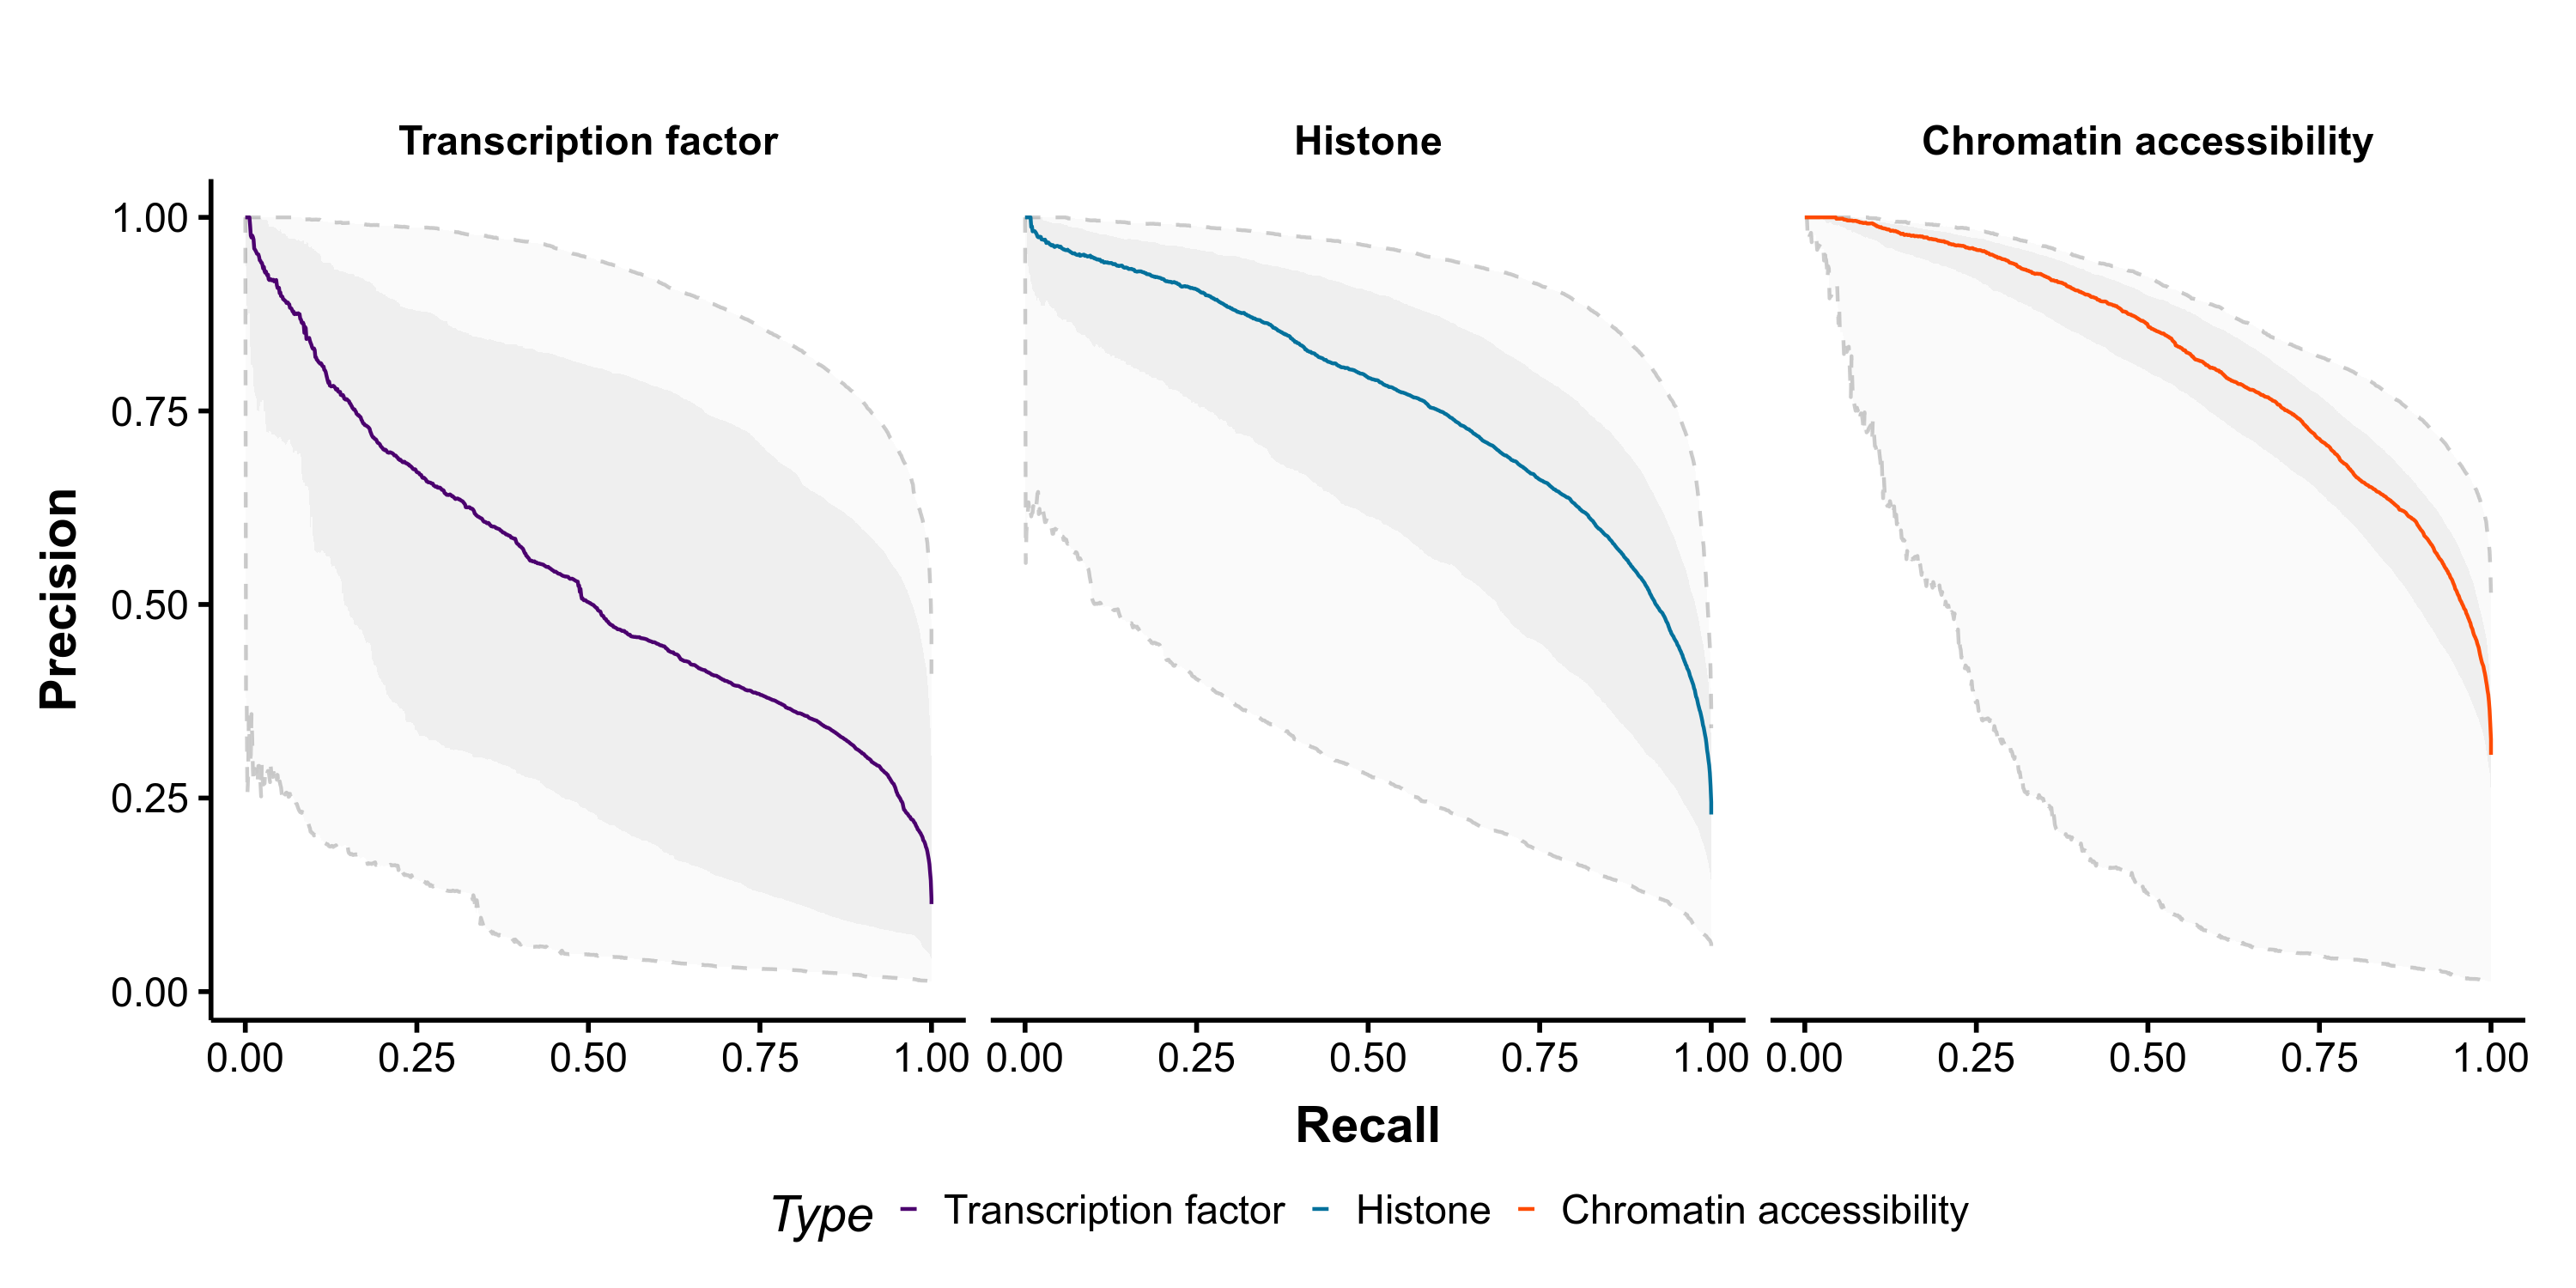

In [35]:
%%R -i plotdata -w 10 -h 5 --units in -r 300

require(ggplot2)
#https://rpubs.com/Koundy/71792
theme_Publication <- function(base_size=14, base_family="Helvetica") {
      library(grid)
      library(ggthemes)
      (theme_foundation(base_size=base_size, base_family=base_family)
       + theme(plot.title = element_text(face = "bold",
                                         size = rel(1.2), hjust = 0.5),
               text = element_text(),
               panel.background = element_rect(colour = NA),
               plot.background = element_rect(colour = NA),
               panel.border = element_rect(colour = NA),
               axis.title = element_text(face = "bold",size = rel(1)),
               axis.title.y = element_text(angle=90,vjust =2),
               axis.title.x = element_text(vjust = -0.2),
               axis.text = element_text(), 
               axis.line = element_line(colour="black"),
               axis.ticks = element_line(),
               panel.grid.major = element_blank(),
               panel.grid.minor = element_blank(),
               legend.key = element_rect(colour = NA),
               legend.position = "bottom",
               legend.direction = "horizontal",
               legend.key.size= unit(0.2, "cm"),
               legend.margin = unit(0, "cm"),
               legend.title = element_text(face="italic"),
               plot.margin=unit(c(10,5,5,5),"mm"),
               strip.background=element_rect(colour="#ffffff",fill="#ffffff"),
               strip.text = element_text(face="bold")
          ))
      
}

scale_fill_Publication <- function(...){
      library(scales)
      discrete_scale("fill","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")), ...)

}

scale_colour_Publication <- function(...){
      library(scales)
      discrete_scale("colour","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")), ...)

}

plotdata$Type = factor(plotdata$target, levels=c('TF','Histone','Chromatin accessibility'))
levels(plotdata$Type) <- c('Transcription factor','Histone','Chromatin accessibility')
print(levels(plotdata$Type))
p = ggplot(plotdata)+geom_ribbon(aes(x=x,ymin=y25,ymax=y75,group=Type),alpha=0.05)+
 geom_ribbon(aes(x=x,ymin=y5,ymax=y95,group=Type),alpha=0.025)+
 geom_line(aes(x=x,y=y95,group=Type),linetype=2,alpha=0.2)+
 geom_line(aes(x=x,y=y5,group=Type),linetype=2,alpha=0.2)+
    geom_line(aes(x=x,y=y50,color=Type))+theme_minimal()+
facet_wrap('~Type',nrow=1)+xlab('Recall')+ylab('Precision')+
scale_color_manual(values=c('#4B006E', '#03719C', '#FE4B03'))+theme_Publication()
ggsave('../figures/perf.prec_recall_4k_467_DC.pdf')
p

In [36]:
pr_y_formatted_fc = ((pr_y_formatted)/(1-pr_y_formatted)) / ((pr_baseline[~np.isnan(aucs),None])/(1-pr_baseline[~np.isnan(aucs),None]))


plotdata = pd.concat([pd.DataFrame({'x':x_formatted,'y50':np.percentile(pr_y_formatted_fc[np.isin(inds_formatted, tf_inds),:], 50, axis=0),
                     'y75':np.percentile(pr_y_formatted_fc[np.isin(inds_formatted, tf_inds),:], 75, axis=0),
                     'y25':np.percentile(pr_y_formatted_fc[np.isin(inds_formatted, tf_inds),:], 25, axis=0),
                     'y5':np.percentile(pr_y_formatted_fc[np.isin(inds_formatted, tf_inds),:], 5, axis=0),
                     'y95':np.percentile(pr_y_formatted_fc[np.isin(inds_formatted, tf_inds),:], 95, axis=0),
                     'target':'TF'}),
                   pd.DataFrame({'x':x_formatted,'y50':np.percentile(pr_y_formatted_fc[np.isin(inds_formatted, histone_inds),:], 50, axis=0),
                     'y75':np.percentile(pr_y_formatted_fc[np.isin(inds_formatted, histone_inds),:], 75, axis=0),
                     'y25':np.percentile(pr_y_formatted_fc[np.isin(inds_formatted, histone_inds),:], 25, axis=0),
                     'y5':np.percentile(pr_y_formatted_fc[np.isin(inds_formatted, histone_inds),:], 5, axis=0),
                     'y95':np.percentile(pr_y_formatted_fc[np.isin(inds_formatted, histone_inds),:], 95, axis=0),
                     'target':'Histone'}),
                   pd.DataFrame({'x':x_formatted,'y50':np.percentile(pr_y_formatted_fc[np.isin(inds_formatted, access_inds),:], 50, axis=0),
                     'y75':np.percentile(pr_y_formatted_fc[np.isin(inds_formatted, access_inds),:], 75, axis=0),
                     'y25':np.percentile(pr_y_formatted_fc[np.isin(inds_formatted, access_inds),:], 25, axis=0),
                     'y5':np.percentile(pr_y_formatted_fc[np.isin(inds_formatted, access_inds),:], 5, axis=0),
                     'y95':np.percentile(pr_y_formatted_fc[np.isin(inds_formatted, access_inds),:], 95, axis=0),
                     'target':'Chromatin accessibility'})])

/tmp/ipykernel_102178/2662797053.py:1: RuntimeWarning: divide by zero encountered in divide
//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/numpy/lib/function_base.py:4576: RuntimeWarning: invalid value encountered in subtract


[1] "Transcription factor"    "Histone"                
[3] "Chromatin accessibility"
Saving 10 x 5 in image


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 239 rows containing missing values (`geom_line()`). 

R[write to console]: 2: Removed 6 rows containing missing values (`geom_line()`). 

R[write to console]: 3: Removed 62 rows containing missing values (`geom_line()`). 



In addition: Warning messages:
1: `legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing` 
2: Removed 239 rows containing missing values (`geom_line()`). 
3: Removed 6 rows containing missing values (`geom_line()`). 
4: Removed 62 rows containing missing values (`geom_line()`). 


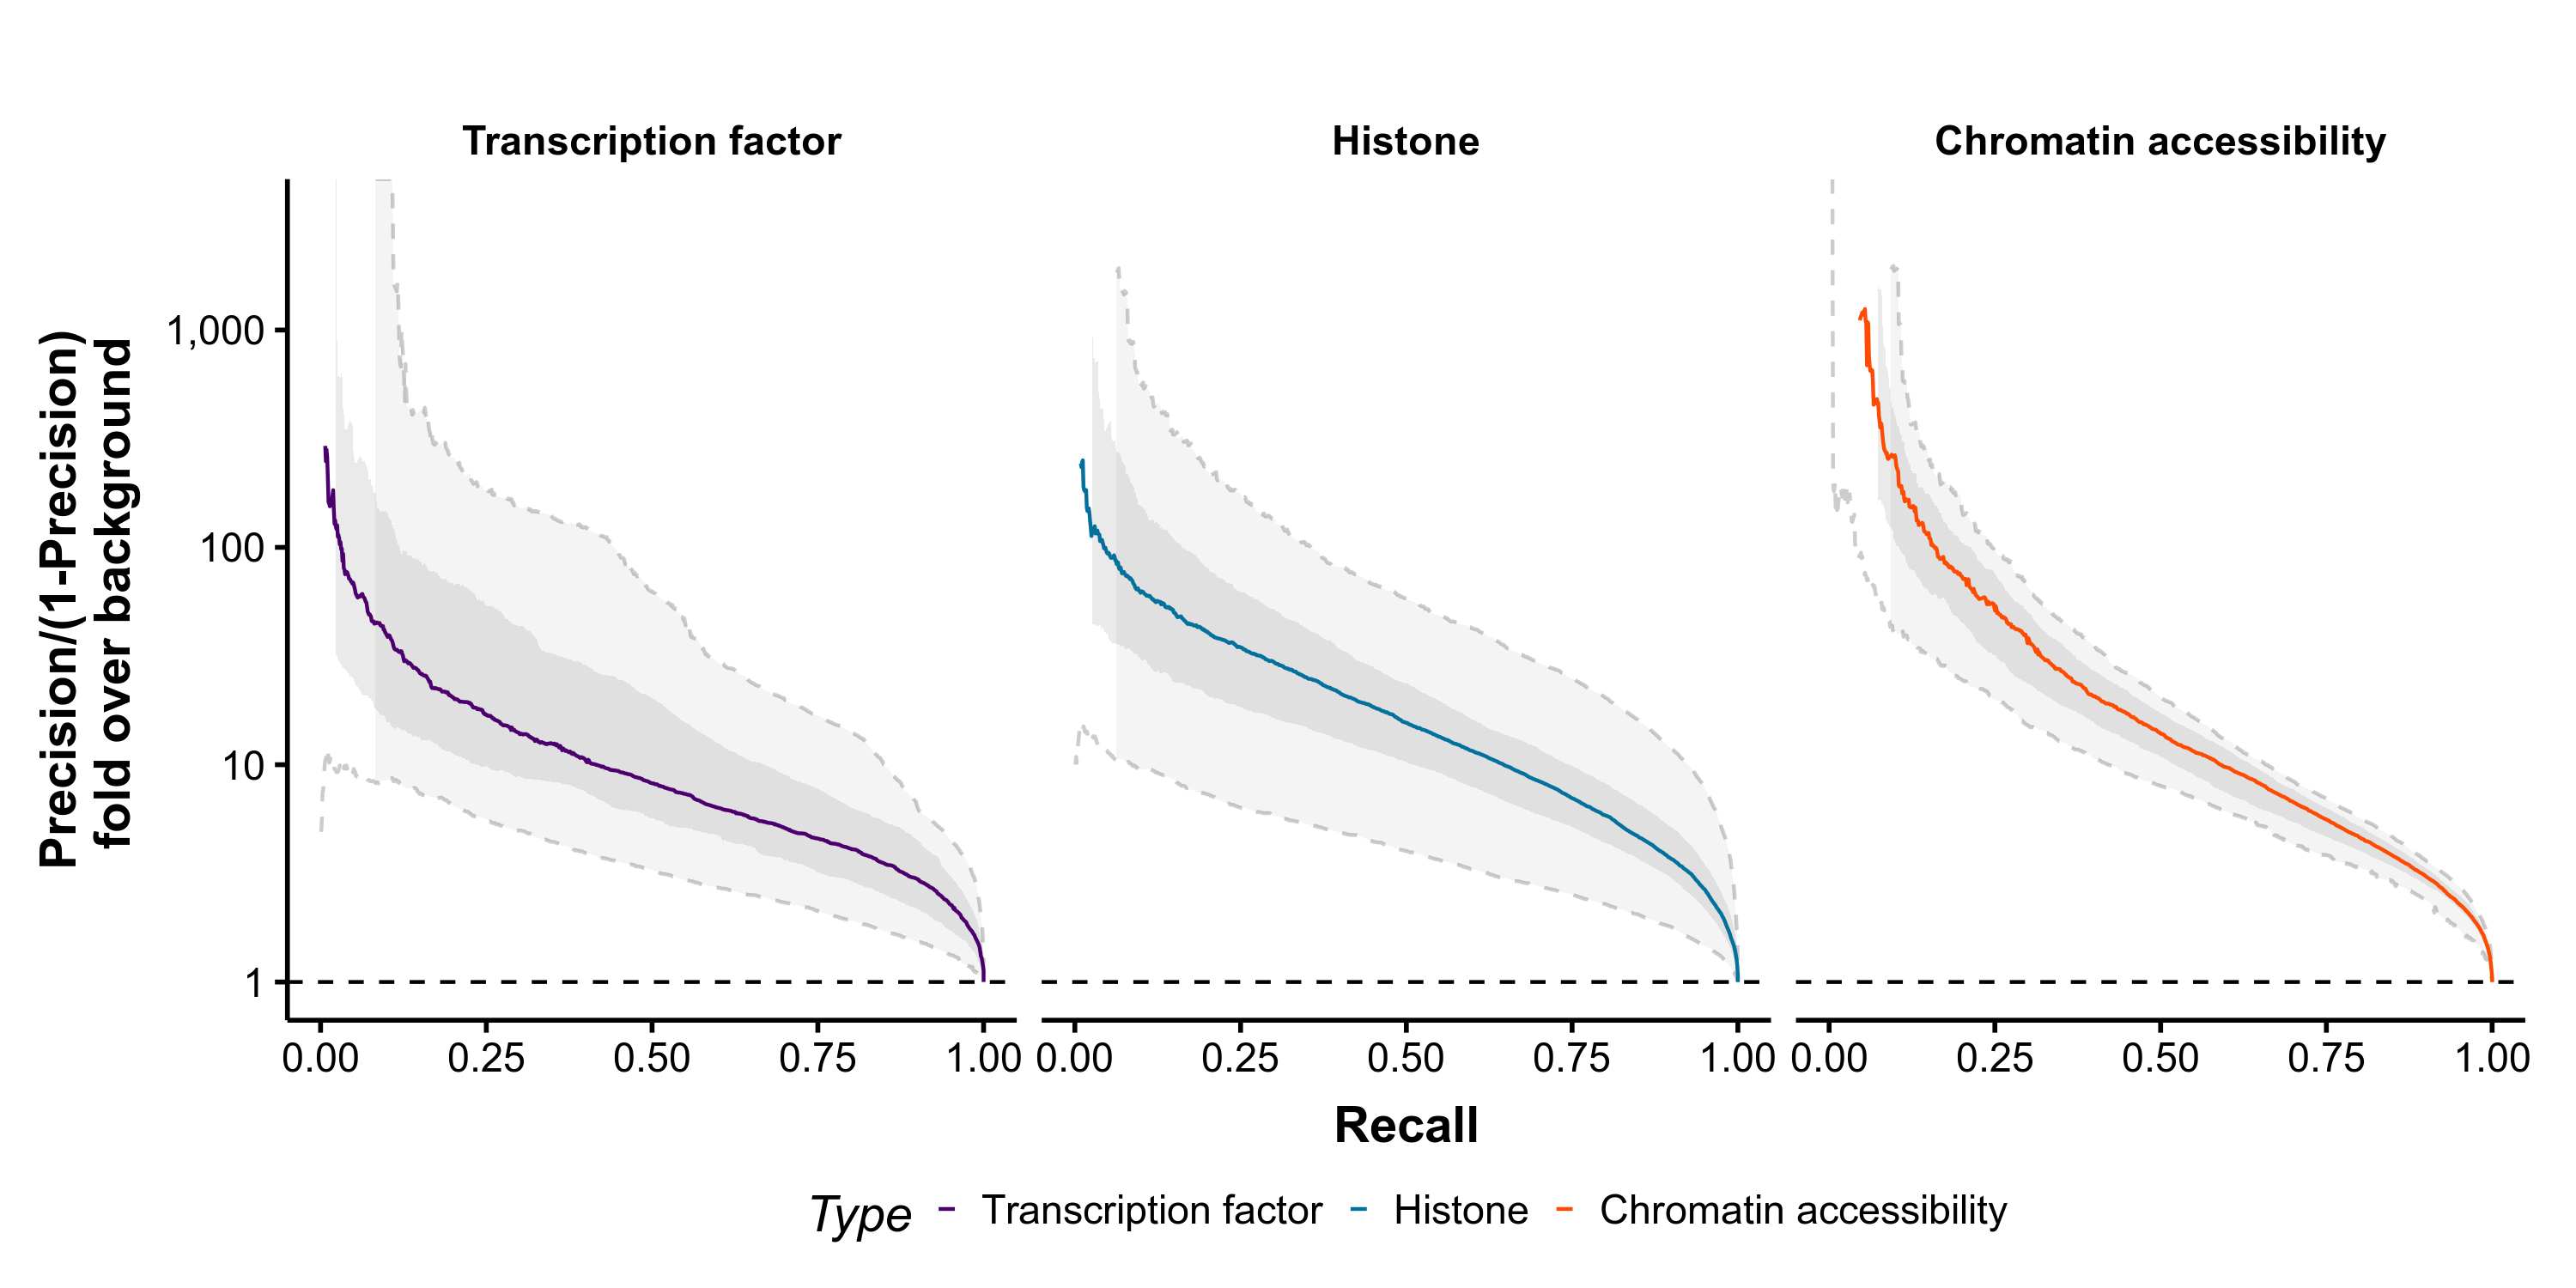

In [37]:
%%R -i plotdata -w 10 -h 5 --units in -r 300

require(ggplot2)

plotdata$Type = factor(plotdata$target, levels=c('TF','Histone','Chromatin accessibility'))
levels(plotdata$Type) <- c('Transcription factor','Histone','Chromatin accessibility')
print(levels(plotdata$Type))
p = ggplot(plotdata)+geom_ribbon(aes(x=x,ymin=y25,ymax=y75,group=Type),alpha=0.1)+
 geom_ribbon(aes(x=x,ymin=y5,ymax=y95,group=Type),alpha=0.05)+
 geom_line(aes(x=x,y=y95,group=Type),linetype=2,alpha=0.2)+
 geom_line(aes(x=x,y=y5,group=Type),linetype=2,alpha=0.2)+
    geom_line(aes(x=x,y=y50,color=Type))+theme_minimal()+
facet_wrap('~Type',nrow=1)+xlab('Recall')+ylab('Precision/(1-Precision)\n fold over background')+
geom_hline(yintercept=1,linetype=2)+
scale_color_manual(values=c('#4B006E', '#03719C', '#FE4B03'))+theme_Publication()+scale_y_log10(labels = scales::comma)

ggsave('../figures/perf.prec_recall_foldchange_4k_467_DC.pdf')
p

In [38]:
plotdata = pd.concat([pd.DataFrame({'x':x_formatted[:-1],'y50':np.percentile(roc_y_formatted[np.isin(inds_formatted, tf_inds),:], 50, axis=0),
                     'y75':np.percentile(roc_y_formatted[np.isin(inds_formatted, tf_inds),:], 75, axis=0),
                     'y25':np.percentile(roc_y_formatted[np.isin(inds_formatted, tf_inds),:], 25, axis=0),
                     'y5':np.percentile(roc_y_formatted[np.isin(inds_formatted, tf_inds),:], 5, axis=0),
                     'y95':np.percentile(roc_y_formatted[np.isin(inds_formatted, tf_inds),:], 95, axis=0),
                     'target':'TF'}),
                   pd.DataFrame({'x':x_formatted[:-1],'y50':np.percentile(roc_y_formatted[np.isin(inds_formatted, histone_inds),:], 50, axis=0),
                     'y75':np.percentile(roc_y_formatted[np.isin(inds_formatted, histone_inds),:], 75, axis=0),
                     'y25':np.percentile(roc_y_formatted[np.isin(inds_formatted, histone_inds),:], 25, axis=0),
                     'y5':np.percentile(roc_y_formatted[np.isin(inds_formatted, histone_inds),:], 5, axis=0),
                     'y95':np.percentile(roc_y_formatted[np.isin(inds_formatted, histone_inds),:], 95, axis=0),
                     'target':'Histone'}),
                   pd.DataFrame({'x':x_formatted[:-1],'y50':np.percentile(roc_y_formatted[np.isin(inds_formatted, access_inds),:], 50, axis=0),
                     'y75':np.percentile(roc_y_formatted[np.isin(inds_formatted, access_inds),:], 75, axis=0),
                     'y25':np.percentile(roc_y_formatted[np.isin(inds_formatted, access_inds),:], 25, axis=0),
                     'y5':np.percentile(roc_y_formatted[np.isin(inds_formatted, access_inds),:], 5, axis=0),
                     'y95':np.percentile(roc_y_formatted[np.isin(inds_formatted, access_inds),:], 95, axis=0),
                     'target':'Chromatin accessibility'})])

[1] "Transcription factor"    "Histone"                
[3] "Chromatin accessibility"
Saving 10 x 5 in image


In addition: Warning message:
`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing` 


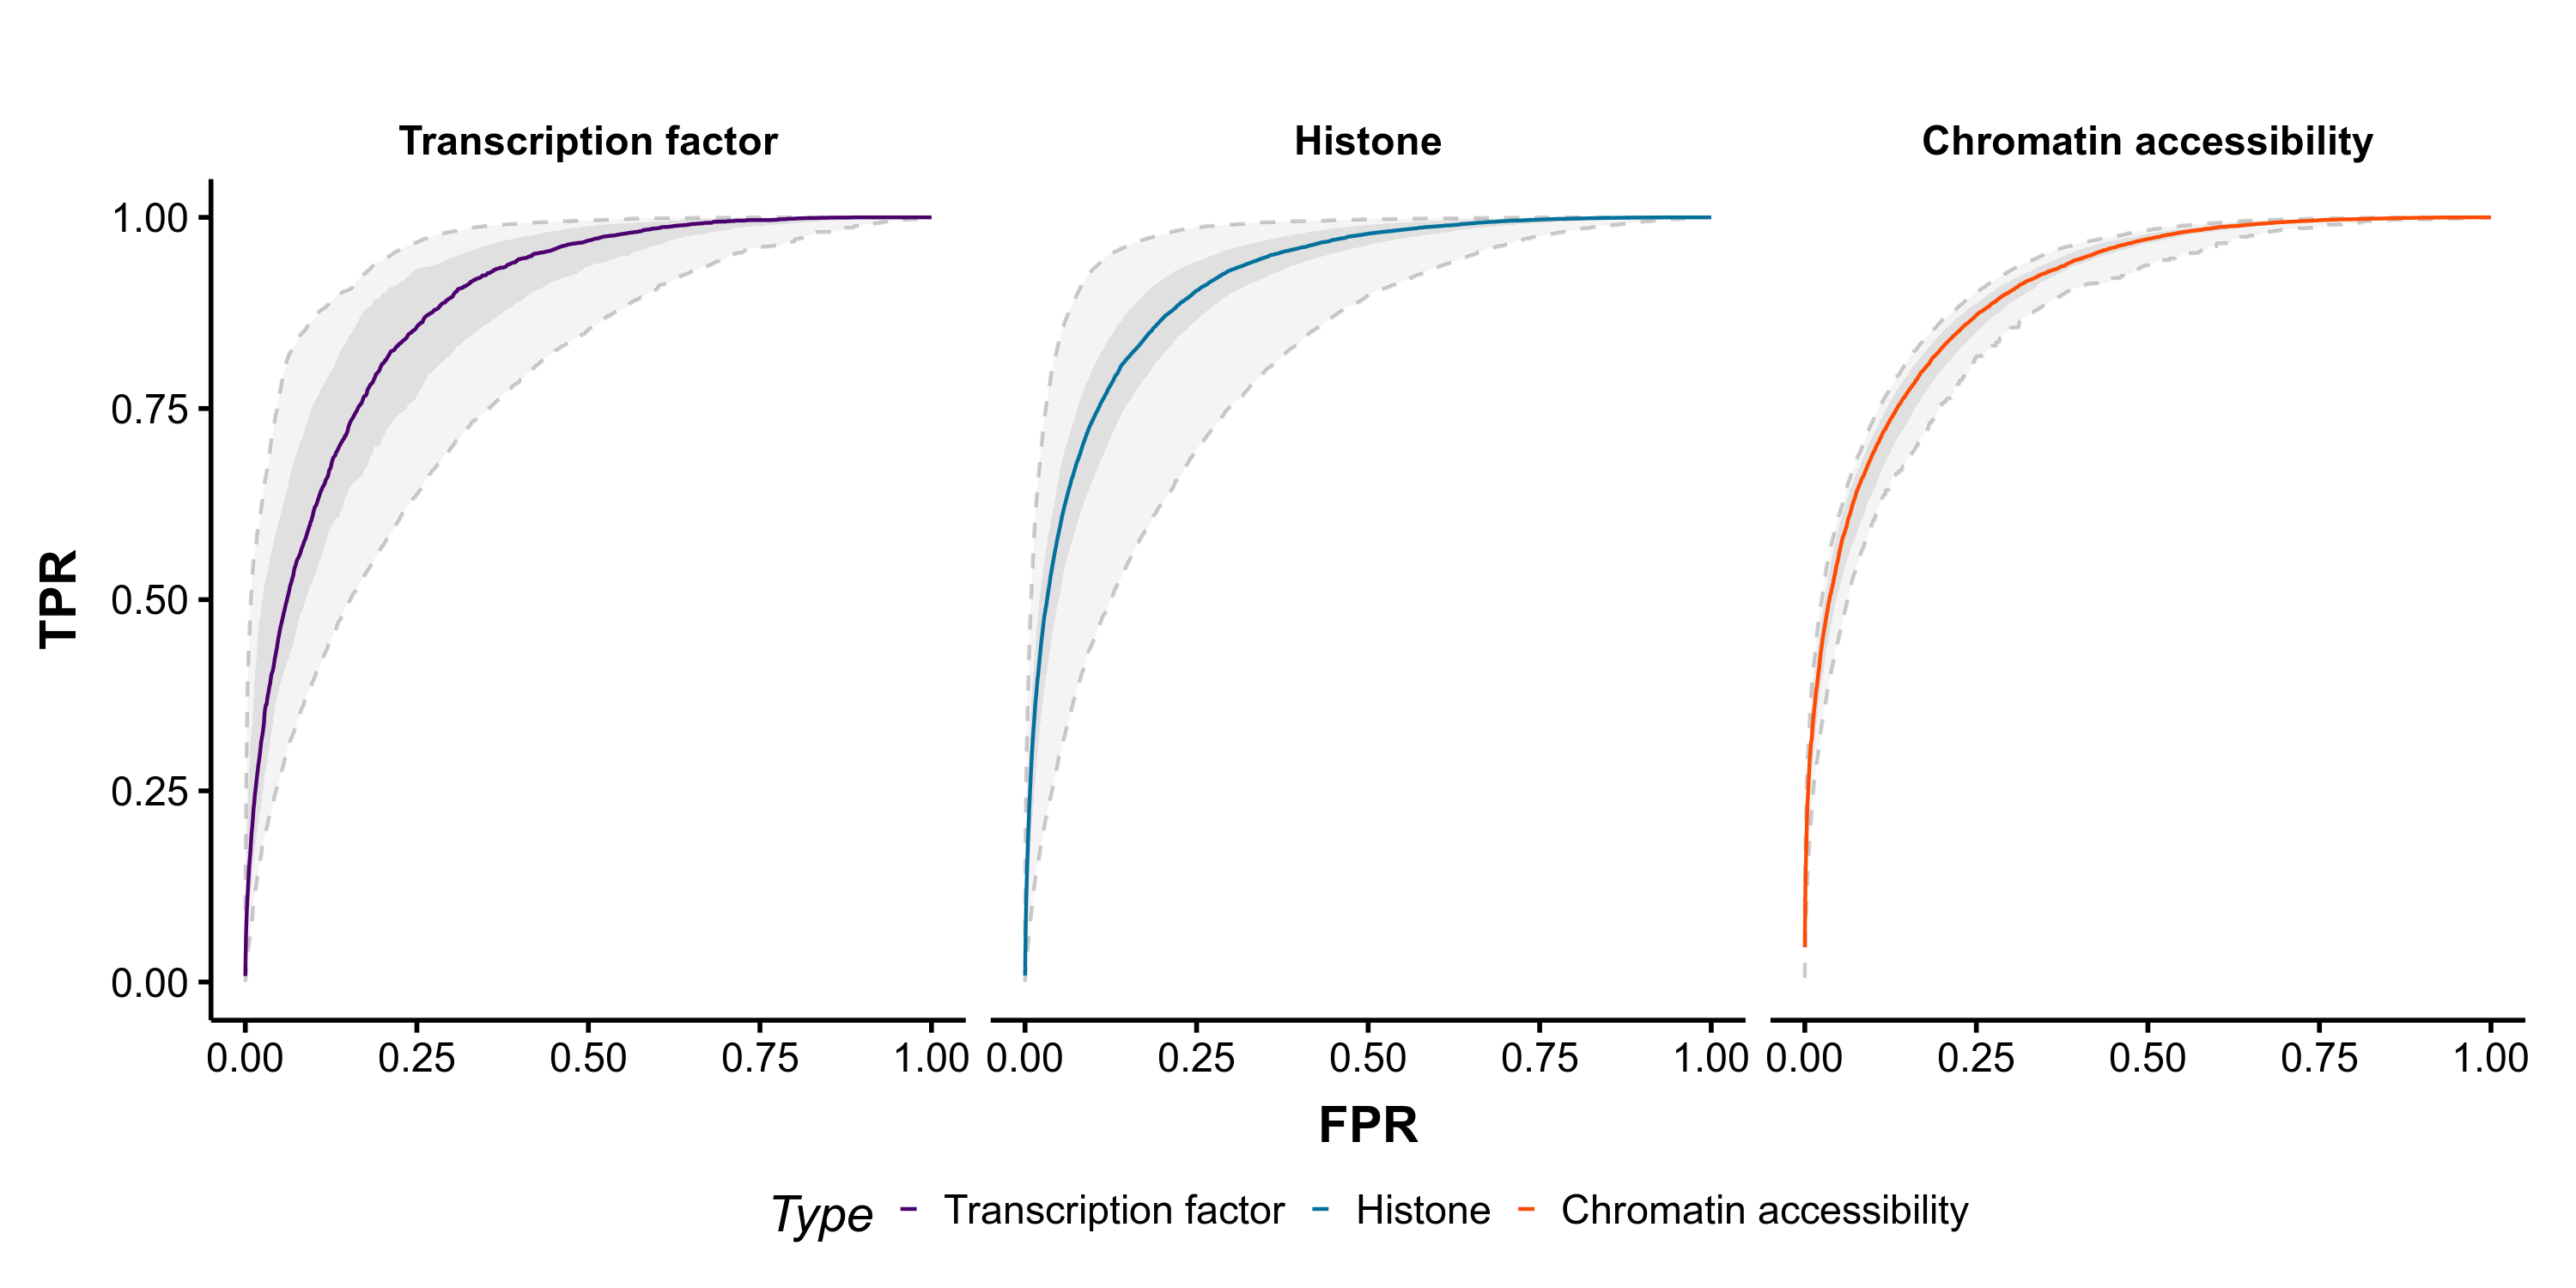

In [39]:
%%R -i plotdata -w 10 -h 5 --units in -r 300

require(ggplot2)


plotdata$Type = factor(plotdata$target, levels=c('TF','Histone','Chromatin accessibility'))
levels(plotdata$Type) <- c('Transcription factor','Histone','Chromatin accessibility')
print(levels(plotdata$Type))
p = ggplot(plotdata)+geom_ribbon(aes(x=x,ymin=y25,ymax=y75,group=Type),alpha=0.1)+
 geom_ribbon(aes(x=x,ymin=y5,ymax=y95,group=Type),alpha=0.05)+
 geom_line(aes(x=x,y=y95,group=Type),linetype=2,alpha=0.2)+
 geom_line(aes(x=x,y=y5,group=Type),linetype=2,alpha=0.2)+
    geom_line(aes(x=x,y=y50,color=Type))+theme_minimal()+
facet_wrap('~Type',nrow=1,scales='free_x')+xlab('FPR')+ylab('TPR')+
scale_color_manual(values=c('#4B006E', '#03719C', '#FE4B03'))+theme_Publication()

ggsave('../figures/perf.roc_4k_467_DC.pdf')
p

In [75]:
seq_len = 1024
feature_size = 467
record_pattern2 = 'tsei_seq{}_nip_feature{}'.format(seq_len, feature_size)

test_prediction = np.load('../model/{}.test_predictions.npy'.format(record_pattern2), allow_pickle=True).item()

preds = test_prediction['predictions']
targets = test_prediction['targets']

In [76]:
#test purpose - change to full pass

aucs2=[]
aps2 = []
pr_ys2 = []
roc_ys2 = []
Ns2 = []
x_formatted = np.linspace(0,1,1000)


for i in range(preds.shape[1]):
    print(i)
    N = targets[:,i].sum()
    if N>25:
        pred = preds[:,i]
        target = targets[:,i]
        auc = roc_auc_score(target,pred)
        ap = average_precision_score(target,pred)
        pr_y, pr_x, _ = precision_recall_curve(target,pred)
        roc_x, roc_y, _ = roc_curve(target,pred)
        aucs2.append(auc)
        aps2.append(ap)
        #reduce the curves to 1000 dots
        roc_ys2.append(interp1d(roc_x, roc_y)(x_formatted))
        pr_ys2.append(interp1d(pr_x, pr_y)(x_formatted))
        Ns2.append(N)
        print(auc)
        print(ap)
    else:
        aucs2.append(np.nan)
        aps2.append(np.nan)
        Ns2.append(np.nan)
        pr_ys2.append(np.nan)
        roc_ys2.append(np.nan)

0
0.8131076646893445
0.10506521273203838
1
0.8290630987935312
0.33167138610516955
2
0.8606298274757949
0.4888580282910041
3
0.8762131951494943
0.3390034601964491
4
0.8975177589919965
0.2668992979598249
5
0.8550875943729854
0.7630789248630774
6
0.8577048860968055
0.7535523034392526
7
0.8576327207000731
0.7761912109280105
8
0.8592555753754783
0.7703187374138221
9
0.8498597110500176
0.1618609183462018
10
0.9053010703936304
0.2723053244453169
11
0.8540813642459673
0.06134085012418923
12
0.8946571778450789
0.6145889275863228
13
0.8955094754979482
0.6735570992675749
14
0.838409608303156
0.45405392596928656
15
0.8779012200948599
0.6020818680596757
16
0.9294882505100236
0.8172838824829016
17
0.8480815458684714
0.3932962411353914
18
0.69803844997007
0.17143255356495288
19
0.8913868414922624
0.6755768347142478
20
0.8341921874885757
0.3838887967380529
21
0.8700872807180238
0.5214995759730394
22
0.9151932889321457
0.7594215943344005
23
0.8095810343151681
0.15830067887440785
24
0.7158711458959413
0

In [77]:
import matplotlib.pyplot as plt
import os

FIGS_DIR = '../figures'

colors = {
    'Transcription Factor': '#4b006e',
    'Histone Mark': '#03719c', 
    'Chromatin Accessibility': '#fe4b03'
}

def model_comparison(source_perf, target_perf, metric, savefile):
    plt.figure(figsize=(6, 6))
    for key, source_data in source_perf.items():
        target_data = target_perf[key]
        print(key, len(source_data))
        plt.scatter(
            source_data, target_data, label=key,
            marker='o', s=6, alpha=0.5, color=colors[key])
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    leg = plt.legend(markerscale=2)
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Sei {0}'.format(metric),
               fontsize=14)
    plt.ylabel('TSei {0}'.format(metric),
               fontsize=14)
    plt.savefig(os.path.join(FIGS_DIR, savefile), dpi=400)
    plt.show()

In [78]:
src_aucs = {'Histone Mark': np.array(aucs)[histone_inds], 'Transcription Factor': np.array(aucs)[tf_inds], 'Chromatin Accessibility': np.array(aucs)[access_inds]}
tar_aucs = {'Histone Mark': np.array(aucs2)[histone_inds], 'Transcription Factor': np.array(aucs2)[tf_inds], 'Chromatin Accessibility': np.array(aucs2)[access_inds]}

Histone Mark 328
Transcription Factor 76
Chromatin Accessibility 63


/tmp/ipykernel_291302/3708744910.py:22: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.


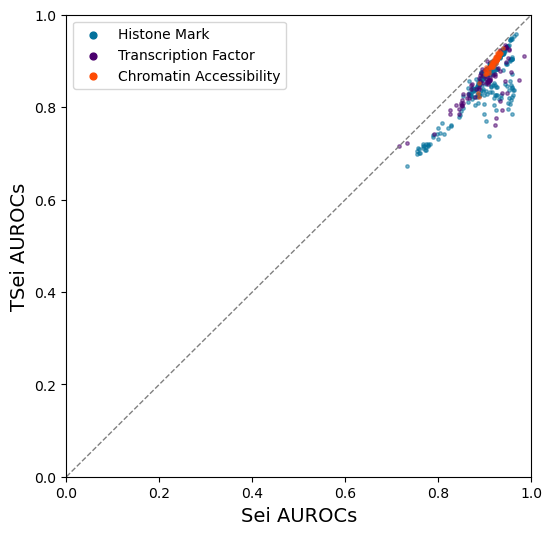

In [79]:
model_comparison(src_aucs,
                 tar_aucs,
                 'AUROCs',
                 'sei_tsei_comparison.AUROCs.png')

In [80]:
src_aps = {'Histone Mark': np.array(aps)[histone_inds], 'Transcription Factor': np.array(aps)[tf_inds], 'Chromatin Accessibility': np.array(aps)[access_inds]}
tar_aps = {'Histone Mark': np.array(aps2)[histone_inds], 'Transcription Factor': np.array(aps2)[tf_inds], 'Chromatin Accessibility': np.array(aps2)[access_inds]}

Histone Mark 328
Transcription Factor 76
Chromatin Accessibility 63


/tmp/ipykernel_291302/3708744910.py:22: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.


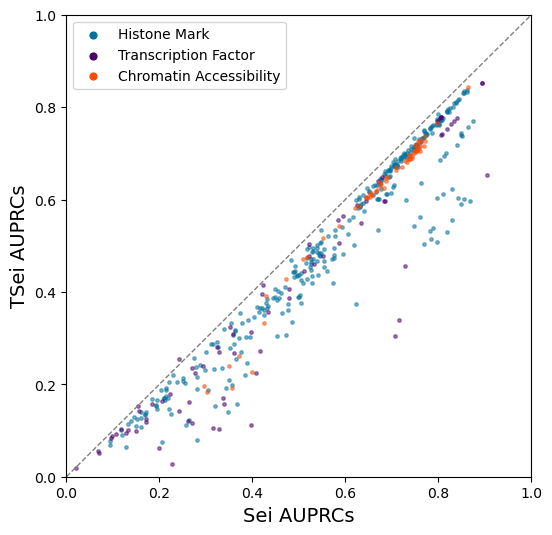

In [81]:
model_comparison(src_aps,
                 tar_aps,
                 'AUPRCs',
                 'sei_tsei_comparison.AUPRCs.png')

## Compare with different sequence length

In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from scipy.interpolate import interp1d
import utils
import preprocess
import data

In [2]:
with open('../training/osat_training_taglist_class.txt') as f:
    classinfo = [rec.strip() for rec in f.readlines()]

histone_inds = []
tf_inds = []
access_inds = []

for i,rec in enumerate(classinfo):
    category = rec.split('\t')[1]
    if category == 'TF':
        tf_inds.append(i)
    elif category == 'Histone':
        histone_inds.append(i)
    else:
        access_inds.append(i)

In [3]:
from tqdm import tqdm

len_list = [1024, 2048, 4096]
len_name_list = ['1k','2k','4k']

auroc_result = {}
auprc_result = {}
for ind, length in enumerate(len_list):
    print(len_name_list[ind])
    seq_len = length
    feature_size = 467
    record_pattern = 'sei_seq{}_nip_feature{}'.format(seq_len, feature_size)

    test_prediction = np.load('../model/{}.test_predictions.npy'.format(record_pattern), allow_pickle=True).item()

    preds = test_prediction['predictions']
    targets = test_prediction['targets']

    #test purpose - change to full pass

    aucs=[]
    aps = []
    pr_ys = []
    roc_ys = []
    Ns = []
    x_formatted = np.linspace(0,1,1000)
    
    
    for i in tqdm(range(preds.shape[1])):
        # print(i)
        N = targets[:,i].sum()
        if N>25:
            pred = preds[:,i]
            target = targets[:,i]
            auc = roc_auc_score(target,pred)
            ap = average_precision_score(target,pred)
            pr_y, pr_x, _ = precision_recall_curve(target,pred)
            roc_x, roc_y, _ = roc_curve(target,pred)
            aucs.append(auc)
            aps.append(ap)
            #reduce the curves to 1000 dots
            roc_ys.append(interp1d(roc_x, roc_y)(x_formatted))
            pr_ys.append(interp1d(pr_x, pr_y)(x_formatted))
            Ns.append(N)
            # print(auc)
            # print(ap)
        else:
            aucs.append(np.nan)
            aps.append(np.nan)
            Ns.append(np.nan)
            pr_ys.append(np.nan)
            roc_ys.append(np.nan)

    auroc_result[len_name_list[ind]] =  {'Histone Mark': np.array(aucs)[histone_inds], 'Transcription Factor': np.array(aucs)[tf_inds], 'Chromatin Accessibility': np.array(aucs)[access_inds]}
    auprc_result[len_name_list[ind]] = {'Histone Mark': np.array(aps)[histone_inds], 'Transcription Factor': np.array(aps)[tf_inds], 'Chromatin Accessibility': np.array(aps)[access_inds]}

1k


100%|██████████| 467/467 [00:10<00:00, 43.27it/s]


2k


100%|██████████| 467/467 [00:08<00:00, 51.97it/s]


4k


100%|██████████| 467/467 [00:07<00:00, 65.72it/s]


In [4]:
from itertools import combinations
import matplotlib.pyplot as plt
import os

FIGS_DIR = '../figures'

colors = {
    'Transcription Factor': '#4b006e',
    'Histone Mark': '#03719c', 
    'Chromatin Accessibility': '#fe4b03'
}

def model_comparison(perf_dict, metric, savefile):
    all_comb = list(combinations(perf_dict.keys(),2))
    
    plt.figure(figsize=(6, 6*3+2))
    for i, comb in enumerate(all_comb):
        src, tar = comb
        source_perf = perf_dict[src]
        target_perf = perf_dict[tar]
    
        for key, source_data in source_perf.items():
            target_data = target_perf[key]
            print(key, len(source_data))
            plt.subplot(3, 1, i+1)
            plt.scatter(
                x = source_data, y = target_data, label=key,
                marker='o', s=6, alpha=0.5, color=colors[key])
            plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
            leg = plt.legend(markerscale=2)
            for lh in leg.legend_handles: 
                lh.set_alpha(1)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.0])
            plt.xlabel('Length {} {}'.format(src, metric),
                       fontsize=14)
            plt.ylabel('Length {} {}'.format(tar, metric),
                       fontsize=14)
    plt.savefig(os.path.join(FIGS_DIR, savefile), dpi=400)
    plt.show()

Histone Mark 328
Transcription Factor 76
Chromatin Accessibility 63
Histone Mark 328
Transcription Factor 76
Chromatin Accessibility 63
Histone Mark 328
Transcription Factor 76
Chromatin Accessibility 63


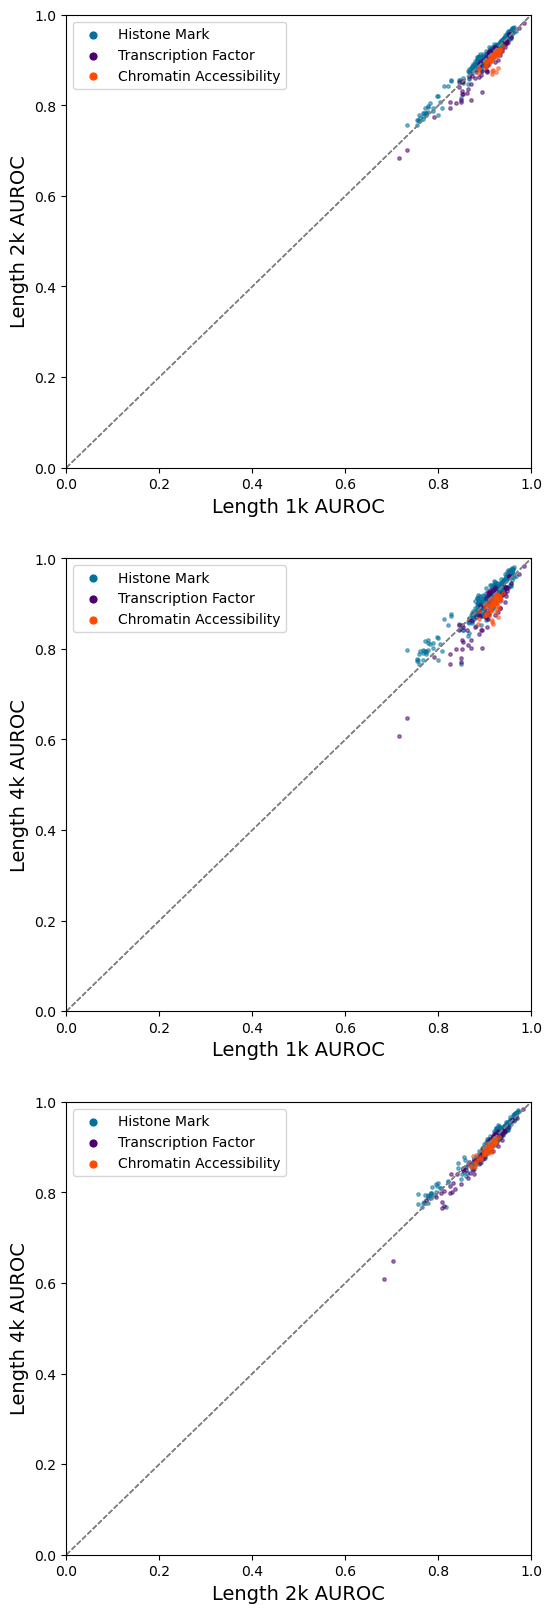

In [5]:
model_comparison(auroc_result, 'AUROC', '1_2_4k_auROC_performance.pdf')

Histone Mark 328
Transcription Factor 76
Chromatin Accessibility 63
Histone Mark 328
Transcription Factor 76
Chromatin Accessibility 63
Histone Mark 328
Transcription Factor 76
Chromatin Accessibility 63


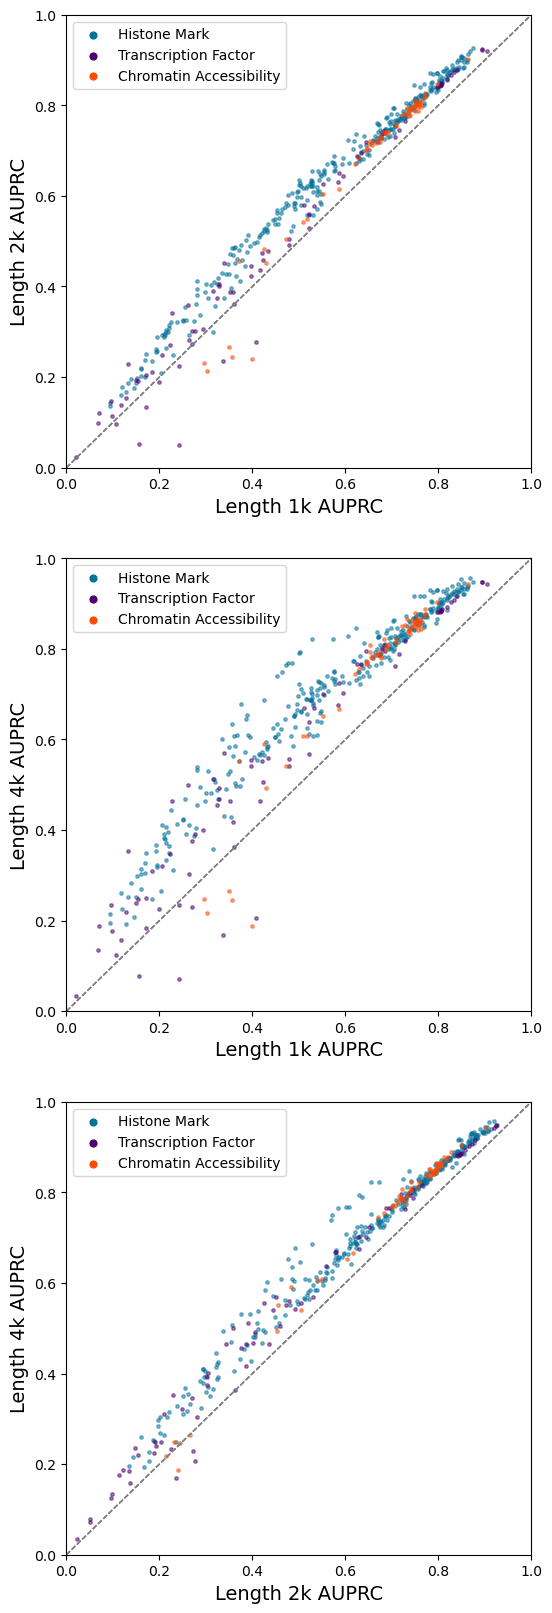

In [6]:
model_comparison(auprc_result, 'AUPRC', '1_2_4k_auPRC_performance.pdf')